In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

In [2]:
employees = pd.read_csv('/Users/baharsharafi/Documents/Insight\
/DataChallenges/employee_retention_data.csv')

# Create a table with head counts on each day for each company 

In [3]:
employees.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
# Remove rows with wrong values for seniority:

wrong_sen_mask = employees['seniority'] > 40
employees.drop(employees[wrong_sen_mask].index,axis = 0,inplace=True)

In [5]:
# Date range of interest: 

rng = pd.date_range(' 2011/01/23','2015/12/13', freq='D')

In [6]:
# Convert join and quit dates to pandas datetime object:

jdates = pd.to_datetime(employees.join_date)
qdates = pd.to_datetime(employees.quit_date)
employees['join_date'] = jdates
employees['quit_date'] = qdates

In [7]:
# Number of companies: 

companies = pd.unique(employees.company_id)

In [8]:
# Initialize the head count data frame:
len_df = len(companies)*len(rng)
head_count_df = pd.DataFrame({'day':np.repeat(np.NaN,(len_df,)),
                              'company_id':np.repeat(np.NaN,(len_df,)),
                          'head_count':np.repeat(np.NaN,(len_df,))})

grouped_by_company = employees.groupby(['company_id'])

for g,g1 in grouped_by_company:
    id = pd.unique(g1.company_id)
    
    start_ind = int((id-1)*len(rng))
    end_ind = int(id*len(rng)-1)
    inds = np.arange(start_ind,end_ind+1)
    
    temp = pd.DataFrame({'company_id':np.repeat(pd.unique(g1.company_id),(len(rng),)),
                           'head_count':np.repeat(np.NaN,(len(rng),))},index = rng)
    
    for day in rng:
        joins = sum(g1.join_date<day)
        quits = sum(g1.quit_date<day)
        head_count = joins-quits
        temp.loc[day,'head_count'] = head_count

        
    temp['day'] = temp.index
    temp['indices'] = inds
    new_temp = temp.set_index('indices')
    
    head_count_df.iloc[inds,:] = new_temp

# Survival 

In [9]:
empl_table = employees.copy()

# Employment duration in days: 
emp_dur = empl_table['quit_date'] - empl_table['join_date']
emp_dur_nona = emp_dur.fillna(value= pd.to_timedelta(len(rng),unit = 'D'))
dur_days = emp_dur_nona.dt.days

### Plot histogram of emplyment duration for those who quit at some point: 
Just to see what the data looks like. Didn't do anything with this information

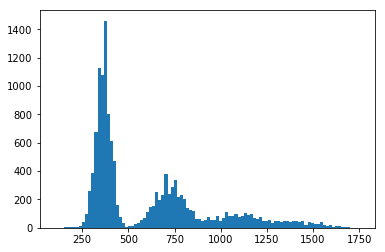

In [10]:
%matplotlib inline
plt.hist(dur_days,bins=100,range = (dur_days.min(),1750))
plt.show()

## Plot the relationship between salary and seniority:
To see if they are terribly correlated which would make their coefficients underdetermined. They are not.

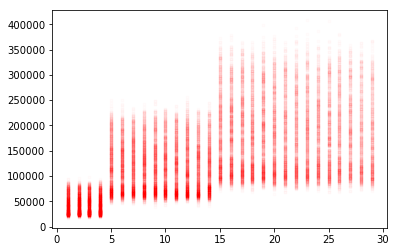

In [11]:
plt.plot(empl_table['seniority'],empl_table['salary'],'r.',alpha = 0.01)

## Create the variables needed for Cox Proportional Hazard regression

In [12]:
# 1 for those who quit during the monitoring time and 0 for those who did not:
empl_table['quit'] = (pd.notnull(empl_table['quit_date'])).astype('int')

# Duration of survival:
empl_table['days'] = dur_days

# Hot one encoding of departments:
pd.unique(empl_table.dept)

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

In [13]:
empl_table['customer_service'] = (empl_table['dept'] == 'customer_service').astype('int')
empl_table['marketing'] = (empl_table['dept'] == 'marketing').astype('int')
empl_table['data_science'] = (empl_table['dept'] == 'data_science').astype('int')
empl_table['engineer'] = (empl_table['dept'] == 'engineer').astype('int')
empl_table['sales'] = (empl_table['dept'] == 'sales').astype('int')
empl_table['design'] = (empl_table['dept'] == 'design').astype('int')

### Normalize salary and seniority and create a new table:

In [14]:
norm_sal = (empl_table['salary']-empl_table['salary'].min())/(empl_table['salary'].max()-empl_table['salary'].min())
norm_sen = (empl_table['seniority']-empl_table['seniority'].min())/(empl_table['seniority'].max()-empl_table['seniority'].min())
emp_norm = empl_table.copy()
emp_norm['salary'] = norm_sal
emp_norm['seniority'] = norm_sen

# Drop the unnecessary columns: 
emp_norm.drop(['employee_id','company_id','dept','join_date','quit_date'],axis = 1,inplace = True)

## Cox proportional Hazard coefficients: 

### Including department:

In [15]:
cph = CoxPHFitter()
cph.fit(emp_norm, duration_col='days', event_col='quit')

cph.print_summary()  # access the results using cph.summary

n=24700, number of events=13508

                    coef  exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95     
seniority         0.2287     1.2569      0.0457  4.9996 0.0000       0.1390      0.3183  ***
salary           -0.5780     0.5610      0.0920 -6.2842 0.0000      -0.7584     -0.3977  ***
customer_service -0.2345     0.7909 245136.3023 -0.0000 1.0000 -480564.1954 480563.7264     
marketing        -0.1363     0.8726 245136.3023 -0.0000 1.0000 -480564.0972 480563.8246     
data_science     -0.1533     0.8579 245136.3023 -0.0000 1.0000 -480564.1142 480563.8076     
engineer         -0.1948     0.8230 245136.3023 -0.0000 1.0000 -480564.1557 480563.7661     
sales            -0.0962     0.9082 245136.3023 -0.0000 1.0000 -480564.0571 480563.8647     
design           -0.1376     0.8714 245136.3023 -0.0000 1.0000 -480564.0985 480563.8233     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.524


## Not including department:

In [16]:
cph = CoxPHFitter()
cph.fit(emp_norm[['salary','seniority','days','quit']], duration_col='days', event_col='quit')

cph.print_summary()  # access the results using cph.summary

n=24700, number of events=13508

             coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
salary    -0.4604     0.6310    0.0533 -8.6386 0.0000     -0.5649     -0.3559  ***
seniority  0.1824     1.2001    0.0360  5.0640 0.0000      0.1118      0.2531  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.520


## Findings:

Department had no effect. Salary and Seniority had opposite effects. Seniority increased the hazard of quitting, while salary decreased it. I ran out of time and couldn't check if the proportional hazard assumption holds. 

Some other information that could be relevant are: level of education, age, marital status, has children or not, whether or not the employee moved from out of town, total compensation (including benefits and any bonus). 